<a href="https://colab.research.google.com/github/Diemlykt/Disease-prediction-apps/blob/main/AlzheimerProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Clinical dataset training

In [1]:
#Install and import library
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
pd.set_option('display.max_columns', None)
%matplotlib inline

#Download and preprocess data

In [2]:
#download Clinical dataset
# https://drive.google.com/file/d/1lPQRLUeDf6oshVGNncpVdkc3BxZ5Nqr-/view?usp=sharing
!gdown 1lPQRLUeDf6oshVGNncpVdkc3BxZ5Nqr-
!unzip /content/Clinical_data.zip

Downloading...
From: https://drive.google.com/uc?id=1lPQRLUeDf6oshVGNncpVdkc3BxZ5Nqr-
To: /content/Clinical_data.zip
100% 274k/274k [00:00<00:00, 26.1MB/s]
Archive:  /content/Clinical_data.zip
  inflating: alzheimers_disease_data.csv  


In [3]:
#preprocess data
df = pd.read_csv('/content/alzheimers_disease_data.csv')
df.info()
# Drop unnecessary columns from the DataFrame
df.drop(['PatientID', 'DoctorInCharge'], axis=1, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2149 entries, 0 to 2148
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PatientID                  2149 non-null   int64  
 1   Age                        2149 non-null   int64  
 2   Gender                     2149 non-null   int64  
 3   Ethnicity                  2149 non-null   int64  
 4   EducationLevel             2149 non-null   int64  
 5   BMI                        2149 non-null   float64
 6   Smoking                    2149 non-null   int64  
 7   AlcoholConsumption         2149 non-null   float64
 8   PhysicalActivity           2149 non-null   float64
 9   DietQuality                2149 non-null   float64
 10  SleepQuality               2149 non-null   float64
 11  FamilyHistoryAlzheimers    2149 non-null   int64  
 12  CardiovascularDisease      2149 non-null   int64  
 13  Diabetes                   2149 non-null   int64

In [4]:
columns = ['Age', 'BMI', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality', 'SystolicBP', 'DiastolicBP', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides', 'MMSE', 'FunctionalAssessment', 'ADL']


# Standardize
scaler = StandardScaler()
df[columns] = scaler.fit_transform(df[columns])

# Save scaler for inference later
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [5]:
#https://www.kaggle.com/code/adhamtarek147/alzheimer-s-disease-prediction/notebook#-5.-Modelling
#split data into features and target
X = df.drop(columns = ['Diagnosis'])
y = df['Diagnosis']

#split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, shuffle = True)

#define hyperparameter grids for each model
param_grids = {
    'Decision Tree': {'max_depth': [3, 5, 7, 12, None]},
    'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7, 12, None]},
    'K-Nearest Neighbors': {'n_neighbors': [3, 5, 7]},
    'Logistic Regression': {'C': [0.1, 1, 10]},
    'Support Vector Machine': {'C': [0.1, 1, 10], 'gamma': [0.1, 1, 'scale', 'auto']},
    'XGBoost': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1], 'max_depth': [3, 5, 7]},
    'CatBoost': {'iterations': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1]}
}

#instantiate classification models with default parameters
models = {
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(),
    'Support Vector Machine': SVC(),
    'XGBoost': XGBClassifier()
}

#fit models using GridSearchCV for hyperparameter tuning
for name, model in models.items():
    grid_search = GridSearchCV(model, param_grids[name], cv = 5, scoring = 'f1')
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    report = classification_report(y_test, y_pred)
    print(f'{name} Classification Report:\n{report}\nBest Parameters: {grid_search.best_params_}\n')

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       277
           1       0.92      0.87      0.90       153

    accuracy                           0.93       430
   macro avg       0.93      0.91      0.92       430
weighted avg       0.93      0.93      0.93       430

Best Parameters: {'max_depth': 5}

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       277
           1       0.96      0.86      0.91       153

    accuracy                           0.94       430
   macro avg       0.94      0.92      0.93       430
weighted avg       0.94      0.94      0.94       430

Best Parameters: {'max_depth': 12, 'n_estimators': 200}

K-Nearest Neighbors Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.87      0.80       277
           1       0.66     

In [6]:
joblib.dump(grid_search.best_estimator_, 'xgboost_model.pkl')

['xgboost_model.pkl']

#IMAGE TRAINING

In [1]:
#download OASIS dataset
#https://drive.google.com/file/d/1pycKDYa9w7j4vhnLsC-3_v44xK2EGX69/view?usp=sharing
!gdown 1pycKDYa9w7j4vhnLsC-3_v44xK2EGX69
!unzip /content/Image.zip

Streaming output truncated to the last 5000 lines.
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_102.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_103.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_104.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_105.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_106.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_107.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_108.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_109.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_110.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_111.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_112.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_113.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_114.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_115.jpg  
  inflating

In [2]:
#import library
import os
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import f1_score
from torchvision import datasets, transforms
from tqdm import tqdm


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device.")

Using cuda device.


In [4]:
#training model
from dataset import Hparams, get_transforms, get_sample_weights, get_data_loaders, get_input_customer
from model2use import ConvBlock, LinearBlock, CNN
from train_test_val_running import train, validate, predict, train_and_validate, EarlyStopping, save_model, predict_customer

hparams = Hparams()
train_loader, val_loader, test_loader = get_data_loaders(hparams)
early_stopping = EarlyStopping(patience=3, mode='max')
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=hparams.learning_rate)
train_losses, train_accuracies, val_losses, val_accuracies = train_and_validate(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=hparams.num_epochs, early_stopping=early_stopping)

train size: 60505, val size: 12965, test size: 12967


Epoch [1/10]: 100%|==========| 945/945 [14:21<00:00,  1.10it/s, accuracy=94.6, loss=0.0143]


	 => train_f1=0.9453, val_loss=0.0127, val_acc=98.5381


Epoch [2/10]: 100%|==========| 945/945 [14:24<00:00,  1.09it/s, accuracy=99.2, loss=0.0123]


	 => train_f1=0.9915, val_loss=0.0121, val_acc=98.8629


Epoch [3/10]: 100%|==========| 945/945 [14:24<00:00,  1.09it/s, accuracy=99.4, loss=0.012]


	 => train_f1=0.9941, val_loss=0.0119, val_acc=99.5127


Epoch [4/10]: 100%|==========| 945/945 [14:24<00:00,  1.09it/s, accuracy=99.4, loss=0.0119]


	 => train_f1=0.9939, val_loss=0.0119, val_acc=98.6154


Epoch [5/10]: 100%|==========| 945/945 [14:24<00:00,  1.09it/s, accuracy=99.7, loss=0.0118]


	 => train_f1=0.9969, val_loss=0.0117, val_acc=99.9381


Epoch [6/10]: 100%|==========| 945/945 [14:24<00:00,  1.09it/s, accuracy=99.4, loss=0.0118]


	 => train_f1=0.9945, val_loss=0.0117, val_acc=99.6906


Epoch [7/10]: 100%|==========| 945/945 [14:24<00:00,  1.09it/s, accuracy=99.5, loss=0.0117]


	 => train_f1=0.9954, val_loss=0.0117, val_acc=99.5282


Epoch [8/10]: 100%|==========| 945/945 [14:24<00:00,  1.09it/s, accuracy=99.6, loss=0.0117]


	 => train_f1=0.9964, val_loss=0.0117, val_acc=99.7370
Early stopping at Epoch 8


In [7]:
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_accuracies(train_accuracies, val_accuracies):
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

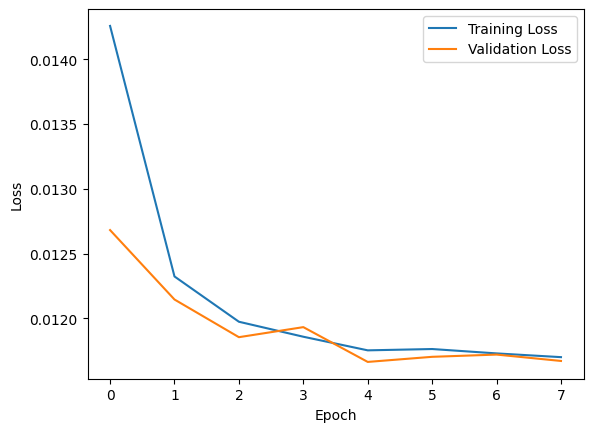

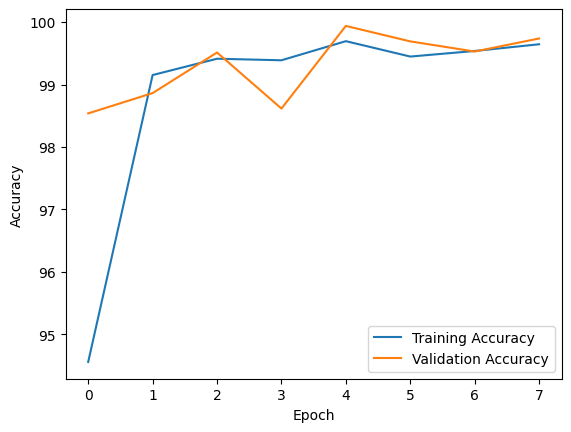

In [8]:
#plot training and validating curve
plot_losses(train_losses, val_losses)
plot_accuracies(train_accuracies, val_accuracies)

In [5]:
test_loss, test_accuracy = validate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 0.0117, Test Accuracy: 99.65%


In [6]:
#save model
save_model(model, hparams)

True

In [25]:
data_iter = iter(test_loader)
images, means, stds, labels = next(data_iter)
print(images.shape)
print(means.unsqueeze(1).shape)

torch.Size([64, 1, 248, 248])
torch.Size([64, 1])


In [28]:
def predict(image_tensor, model):
    with torch.no_grad():
        mean = torch.mean(image_tensor).unsqueeze(0)
        std = torch.std(image_tensor).unsqueeze(0)
        output = model(image_tensor.unsqueeze(0), mean, std)
        predicted_class = torch.argmax(output, dim=1)
        return predicted_class.item()

# Example prediction from test_loader
data_iter = iter(test_loader)
images, means, stds, labels = next(data_iter)

# Predict for the first image in the batch
image = images[0]
prediction = predict(image, model)

print("Predicted class:", prediction)

Predicted class: 2
